In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"



# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras import Input

assert tf.__version__ >= "2.0"



# Common imports
import numpy as np
import os



# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)



In [2]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [3]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [4]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [5]:
len(INPUT_CHARS)

38

In [6]:
#INPUT_CHARS.insert("<eos>")

In [7]:
OUTPUT_CHARS = "0123456789-"

In [8]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [9]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [10]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [11]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [12]:
random_dates(1)

(['June 01, 7451'], ['7451-06-01'])

In [13]:
len(OUTPUT_CHARS)

11

In [14]:
OUTPUT_CHARS

'0123456789-'

# Models

## Simple encoder-decoder

In [16]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 64
units = 512
BATCH_SIZE = 64

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings_layer  = keras.layers.Embedding(
    len(INPUT_CHARS)+1 , encoder_embedding_size) #+1 because of padding
encoder_embeddings = encoder_embeddings_layer(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS)+2 , decoder_embedding_size) #+2 because padding + EOS
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS)+2) #+1

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])


In [17]:

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

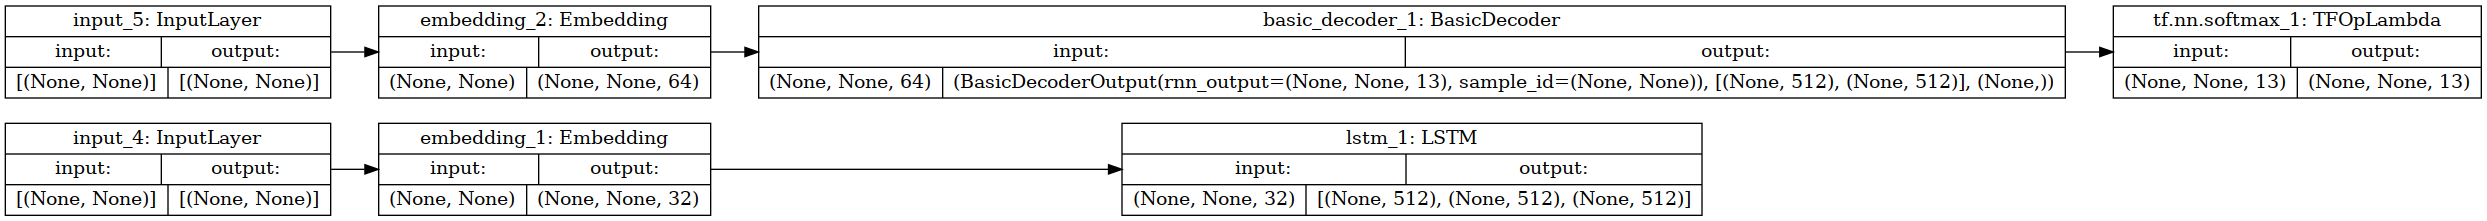

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [19]:
np.full([10000], 10)

array([10, 10, 10, ..., 10, 10, 10])

tf.config.gpu.set_per_process_memory_fraction(0.75)
tf.config.gpu.set_per_process_memory_growth(True)

In [20]:
X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)
X = X_train
Y = Y_train
X_decoder = np.c_[tf.zeros((10000, 1), tf.int32).numpy(), Y_train[:,:-1].numpy()]
X_val_decoder = np.c_[tf.zeros((2000, 1), tf.int32).numpy(), Y_valid[:,:-1].numpy()]
history = model.fit([X, X_decoder], Y, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
157/157 [==============================] - 4s 11ms/step - loss: 1.8456 - accuracy: 0.3248
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 1.4578 - accuracy: 0.4102
Epoch 3/20
157/157 [==============================] - 2s 11ms/step - loss: 1.3816 - accuracy: 0.4544
Epoch 4/20
157/157 [==============================] - 2s 11ms/step - loss: 1.1662 - accuracy: 0.5387
Epoch 5/20
157/157 [==============================] - 2s 11ms/step - loss: 0.7749 - accuracy: 0.6926
Epoch 6/20
157/157 [==============================] - 2s 11ms/step - loss: 0.3530 - accuracy: 0.8732
Epoch 7/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0775 - accuracy: 0.9866
Epoch 8/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0369 - accuracy: 0.9943
Epoch 9/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0080 - accuracy: 0.9999
Epoch 10/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0040 - accura

### Prediction

In [45]:
max_output_length = Y_train.shape[1]
max_input_length =  X_train.shape[1]

def prediction_enc_dec(date):
    inputs = prepare_date_strs([date], INPUT_CHARS)
    #If inputs does not have the right length, the prediction will change (ex: 'April 10, 6024')
    if inputs.shape[1] < max_input_length:
        inputs = tf.pad(inputs, [[0, 0], [0, max_input_length - inputs.shape[1]]])
    y_pred = tf.fill(dims=(1, 1), value=0)#, np.full([1], 1)])
    result = ""
    for t in range(0, max_output_length):
        pad_size = max_output_length - y_pred.shape[1]
        dec_input = tf.pad(y_pred, [[0, 0], [0, pad_size]])
        y_pred_current = model.predict([inputs, dec_input])[:,t:t+1]
        #need to put t:t+1 to get shape=(1,1) after applied tf.argmax fot tf.concat
        if np.argmax(y_pred_current) == 12: # if end of sentence predicted stop the prediction
            result += OUTPUT_CHARS[np.argmax(y_pred_current)-1]
            return result
        result += OUTPUT_CHARS[np.argmax(y_pred_current)-1]
        y_pred = tf.concat([y_pred, tf.argmax(y_pred_current, axis=-1, output_type=tf.int32)], 1) 
        #tf.argmax and not np.argmax otherwise tf.concat does not work, 
        #with tf.int32 because dec_input has type tf.int32, axis=-1 to get the correct index


    return result

In [46]:
result = prediction_enc_dec('April 10, 6024')
result

'6024-04-10'

In [47]:
result = prediction_enc_dec('September 10, 6024')
result

'6024-09-10'